# Experiment Main

In [1]:
import pandas as pd
import numpy as np
import itertools
from tqdm.notebook import tqdm
import pickle

import torch
import torch.utils.data as data
from torch.utils.data import DataLoader
import torch.utils.data.sampler as sampler
import torch.nn as nn
import torch.nn.functional as F

from matplotlib import pyplot as plt
from collections import defaultdict
import warnings
from sklearn.preprocessing import LabelEncoder
import random
from datetime import datetime
import pytz
import line_profiler

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

### Fix Random Seeds

In [2]:
def same_seeds(seed):
  torch.manual_seed(seed)
  if torch.cuda.is_available():
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)  
  np.random.seed(seed)  
  torch.backends.cudnn.benchmark = False
  torch.backends.cudnn.deterministic = True

same_seeds(0)

## Prepare Data

In [3]:
CONTEXT_REPS = pd.read_pickle('../../data/CONTEXT_REPS_CLEAN_ASID.pkl')
STREAM_ITEM_DICT = pd.read_pickle('../../data/stream_item_dict.pkl')
BERT_BY_IDX_DF = pd.read_pickle('../../data/bert_by_idx_pca.pkl')
BOUGHT_DICT = pd.read_pickle('../../data/bought_dict.pkl')

In [4]:
CONTEXT_REPS.shape, len(STREAM_ITEM_DICT), BERT_BY_IDX_DF.shape, len(BOUGHT_DICT)

((1333083, 219), 7701, (162189, 160), 79207)

In [4]:
USER_LIST = CONTEXT_REPS.index.get_level_values('asid').unique().tolist()

In [6]:
LB_ITEMS = ['item_id'] + [f'i{x}' for x in range(160)]
INPUT_DF_COL__USR = CONTEXT_REPS.columns.to_list()
INPUT_DF_COL = INPUT_DF_COL__USR + LB_ITEMS

'''
METHOD FOR BOTH EXP_REPLAY & DQN
Convert state format to model input format
'''
def get_input_tensor(input_state, current_stream, with_tensor=False):
  # Get item feats
  # STREAM_ITEM_DICT: 要拿到對的 STREAM!!!
  item_list = STREAM_ITEM_DICT[current_stream]
  item_feat = BERT_BY_IDX_DF.loc[item_list].reset_index().rename(columns={'index': 'item_id'})

  # Fill in other context
  stream_item_feat = pd.DataFrame([input_state]*len(item_list)).reset_index(drop=True)
  
  # Merge with items
  stream_item_feat = stream_item_feat.merge(item_feat, left_index=True, right_index=True).astype('float32')
  
  # Convert to tensor
  if with_tensor: 
    stream_item_feat_tensor = df_to_tensor(stream_item_feat)
    return stream_item_feat_tensor, stream_item_feat
  else:
    return stream_item_feat

In [7]:
'''
METHOD FOR BOTH EXP_REPLAY & DQN

Generate series: whether elements in A existed in list B
A, B: List
return: pd.Series
example:
  A: [1, 2, 4, 5]
  B: [1, 2, 3, 4, 5, 6, 7]
  return: Series([1, 1, 0, 1, 1, 0, 0], index=[1, 2, 3, 4, 5, 6, 7])
'''
def gen_exist_series(A, B):
  return [int(item in A) for item in B]

In [8]:
def df_to_tensor(input_df):
  return torch.tensor(input_df.values).to(DEVICE).float()

---

## Replay

In [9]:
class ReplayBuffer:
  def __init__(self, max_memory=100000, discount=.9, model_output_shape=1):
    """
    Setup
    max_memory: the maximum number of experiences we want to store
    memory: a list of experiences
    discount: the discount factor for future experience
    In the memory the information whether the game ended at the state is stored seperately in a nested array
    [...
    [experience, game_over]
    [experience, game_over]
    ...]
    """
    self.max_memory = max_memory
    self.memory = list()
    self.discount = discount
    self.model_output_shape = model_output_shape

  def remember(self, states, game_over):
    # Save a state to memory
    self.memory.append([states, game_over])
    # We don't want to store infinite memories, so if we have too many, we just delete the oldest one
    if len(self.memory) > self.max_memory:
      del self.memory[0]

  def get_batch(self, eval_net, target_net, structure, batch_size=10):
    # How many experiences do we have?
    len_memory = len(self.memory)

    # Calculate the number of actions that can possibly be taken in the game.
    # Actions: 0 = not recommend, 1 = recommend
    num_actions = self.model_output_shape

    # Dimensions of our observed states, ie, the input to our model.
    # Memory:  [
    #   [ [ [stream, next_stream], [...state], action, reward, next_state_idx], game_over],
    #   [ [ [stream, next_stream], [...state], action, reward, nexr_state_idx], game_over],
    #   ...
    # ]
    env_dim = len(INPUT_DF_COL)

    inputs = pd.DataFrame()
    targets = torch.tensor([], dtype=torch.float32).to(DEVICE)
    
    
    # We draw states to learn from randomly
    for i, idx in enumerate(np.random.randint(0, len_memory, size=min(len_memory, batch_size))):  
      # Here we load one transition <s, a, r, s'> from memory
      streams, state_t, action_t, reward_t, state_tp1 = self.memory[idx][0]
      current_stream, next_stream = streams
      game_over = self.memory[idx][1]

      '''
      修改倒入 state 的方式 input = (state - item) + item_feat
      拆掉 model_predict 成 function

      here should be state_t * all_items
      '''
      state_tensor, state_t = get_input_tensor(state_t, current_stream, with_tensor=True)
      # puts state into input
      inputs = pd.concat([inputs, state_t], axis=0)

      reward_t = df_to_tensor(reward_t).view(len(reward_t), 1)

      '''
      每個 actions 都會被 predict 一個成績/reward
      '''
      # if the game ended, the reward is the final reward
      if game_over:  # if game_over is True
        current_target = reward_t
      else:
        state_tp1, _ = get_input_tensor(state_tp1, next_stream, with_tensor=True)
        if target_net == None:
          with torch.no_grad():
            Q_sa = torch.max(eval_net(state_tp1))
        elif structure == 'target':
          with torch.no_grad():
            Q_sa = torch.max(target_net(state_tp1))
        elif structure == 'double':
          with torch.no_grad():
            _, selected_actions = eval_net(state_tp1).max(dim=0, keepdim=True)
            Q_sa = target_net(state_tp1).gather(dim=0, index=selected_actions)
          
        # r + gamma * max Q(s',a')
        # current_target = reward_t + self.discount * Q_sa
        current_target = reward_t.add(Q_sa, alpha=self.discount)

      targets = torch.cat((targets, current_target), 0)
    return inputs, targets

## Epsilon

In [10]:
from abc import ABC, abstractmethod
import math

class Epsilon(ABC):
  @abstractmethod
  def clear(self):
    pass
  
  @abstractmethod
  def get_epsilon(self, key):
    pass
  
  @abstractmethod
  def update_at_step(self, key, data, delta):
    pass
  
  @abstractmethod
  def update_at_epoch(self, data):
    pass
  
  # @abstractmethod
  # def update_at_epsisode():
  #   pass


class Decay(Epsilon):
  # Ref: Decay(0.5, 0.85)
  '''
  Epsilon Decay EE method with update/decay at epoch
  '''
  def __init__(self, initial, epoch_decay, step_decay=1.0):
    self.initial = initial
    self.epoch_decay, self.step_decay = epoch_decay, step_decay
    self.epsilon = self.initial
    
  def clear(self):
    self.epsilon = self.initial # should be 4 for origin setting
    
  def get_epsilon(self, key):
    return self.epsilon
  
  def update_at_step(self, key, data, delta):
    # origin setting
    pass
    # exponentially
    # self.epsilon *= self.step_decay
    
  def update_at_epoch(self, data):
    # origin settings
    epoch = data
    self.epsilon = 4 / ((epoch + 1) ** (1 / 2))
    # exponentially
    # self.epsilon *= self.epoch_decay


class VDBE(Epsilon):
  # VDBE(0.5, 0.01)
  def __init__(self, initial, sigma):
    self.initial = initial
    self.sigma = sigma

  def clear(self):
    self.epsilon = defaultdict(lambda: self.initial)

  def get_epsilon(self, key):
    return self.epsilon[key]
  
  def update_at_step(self, key, data, delta):
    td_error = data
    coeff = math.exp(-abs(td_error) / self.sigma)
    f = (1.0 - coeff) / (1.0 + coeff)
    self.epsilon[key] = delta * f + (1.0 - delta) * self.epsilon[key]
  
  def update_at_epoch(self, data):
    pass

## DQN

In [15]:
class DQN(object):
  def __init__(self, structure, exp_replay, epsilon, num_episode, epochs, batch_size, lr, switch_param_threshold, single_reward):
    self.eval_net = Net()
    self.target_net = Net() if not structure == 'vanilla' else None
    self.structure = structure
    self.optimizer = torch.optim.Adam(self.eval_net.parameters(), lr=lr)
    self.loss_fn = nn.MSELoss()
    self.exp_replay = exp_replay
    self.epsilon = epsilon
    self.num_episode = num_episode
    self.epochs = epochs
    self.batch_size = batch_size
    self.switch_param_threshold = switch_param_threshold
    self.single_reward = single_reward
    self.win_list = []
    self.score_list = []
    self.loss_list = []
    self.learn_step_counter = 0

  # Environment Methods
  def __episodes(self):
    # return USER_LIST[:self.num_episode]
    return np.random.choice(USER_LIST, self.num_episode, replace=False)
  
  def __user_episode_context(self):
    self.user_all_streams = CONTEXT_REPS.xs(self.asid, level="asid")
    self.stream_list = self.user_all_streams.index
    self.final_stream = max(self.stream_list)
    
  def _print_status(self):
    if self.rec_cnt % 100 == 0:
      self.win_list.append(self.win_cnt)
      self.score_list.append(self.score)
      self.loss_list.append(self.loss)
      print(f'[{len(self.win_list)}] win_cnt: {self.win_cnt} | score: {self.score} | asid: {USER_LIST.index(self.asid)} | loss: {self.loss:.2f} | explore: {self.explore} | exploit: {self.exploit}')
      self.win_cnt = 0
      self.score = 0
      self.loss = 0
      self.explore = 0
      self.exploit = 0
      
  def reward(self):
    '''
    Comparison function for reward, 考慮「所有」歷史購買紀錄
    '''
    real_bought_ids = BOUGHT_DICT[self.asid]
    real_bought_ids_series = gen_exist_series(real_bought_ids, self.stream_items)
    
    reward_list = [a & b for a, b in zip(real_bought_ids_series, self.action_ids)]

    # Reward Count 
    self.rec_cnt += 1
    if sum(reward_list) > 0:
      self.win_cnt += 1
      self.score += sum(reward_list)
    self._print_status()
    
    if self.single_reward:
      return pd.Series(reward_list, index=self.stream_items)
    else:
      return pd.Series(list(map(lambda x: x * sum(reward_list), reward_list)), index=self.stream_items)

  # Agent Methods
  def __choose_actions(self):
    if np.random.rand() <= self.epsilon.get_epsilon(self.asid):
    # if len(self.exp_replay.memory) < 1:
      # Explore by randomly select 10/n items from candidate_items
      # Get all items from the stream
      self.explore += 1
      selected_actions = random.sample(self.stream_items, 10) if len(self.stream_items) > 10 else self.stream_items
    else:
      # Exploit by choosing action from the model's prediction
      self.exploit += 1
      selected_actions = self.__agent_predict()
    x = pd.Series(0, index=self.stream_items)
    x.loc[selected_actions] = 1
    return x
    
  def q_value(self): 
    if type(self.epsilon) == Decay: return 0
    with torch.no_grad():
      predicts = self.eval_net(self.full_input).flatten()    
    actions_idx = np.where(self.action_ids.values == 1)[0]
    q_val = predicts[actions_idx].mean()
    return q_val

  def __agent_predict(self):
    with torch.no_grad():
      predicts = self.eval_net(self.full_input).flatten()
    if len(predicts) > 10:
      top10_idx = torch.topk(predicts, 10).indices.cpu()
      actions = self.candidate_actions.iloc[top10_idx]['item_id'].values
    else:
      actions = self.candidate_actions['item_id'].values
    return actions

  def __train_agent_batch(self, inputs, targets):
    self.optimizer.zero_grad()
    outputs = self.eval_net(inputs)
    loss = self.loss_fn(outputs, targets)
    # Add CL Regularization Term
    loss.backward()
    self.optimizer.step()
    return loss.item()

  # MAIN TRAIN
  def train(self):
    self.eval_net.to(DEVICE)
    if self.target_net:
      self.target_net.to(DEVICE)
    self.eval_net.train(True)
    self.epsilon.clear()
    self.loss = 0.
    self.rec_cnt = 0
    self.win_cnt = 0
    self.explore = 0
    self.exploit = 0
    self.score = 0

    # ------------------- Episode (User) -------------------------------
    for asid in tqdm(USER_LIST):
      self.asid = asid
      self.__user_episode_context()

      # ----------------- Runs (User x All_Stream) ---------------------
      for i, stream in enumerate(self.stream_list):
        game_over = stream == self.final_stream
        self.current_stream = stream
        self.current_state = self.user_all_streams.loc[stream]
        self.stream_items = STREAM_ITEM_DICT[self.current_stream]
        self.full_input, self.candidate_actions = get_input_tensor(self.current_state, self.current_stream, with_tensor=True)

        # --------------- Explore/Exploit Section ----------------------
        self.action_ids = self.__choose_actions()

        # --------------- Get next state & info to store ---------------
        reward = self.reward()
        next_state = self.user_all_streams.loc[self.stream_list[i + 1]] if not game_over else []
        next_stream = None if (i + 1) == len(self.stream_list) else self.stream_list[i + 1]
        self.exp_replay.remember([[stream, next_stream], self.current_state, self.action_ids, reward, next_state], game_over)
        self.learn_step_counter += 1
        if self.target_net and (self.learn_step_counter % self.switch_param_threshold == 0):
          self.target_net.load_state_dict(self.eval_net.state_dict())


        # --------------- Load batch of experiences --------------------
        inputs, targets = self.exp_replay.get_batch(self.eval_net, self.target_net, self.structure, batch_size=self.batch_size)
        inputs = df_to_tensor(inputs)
        # store pre-training value for td_error
        old_Q = self.q_value()
        batch_loss = self.__train_agent_batch(inputs, targets)
        # store post-training value for td_error
        new_Q = self.q_value()
        self.loss += batch_loss

        # --------------- Update with TD error -------------------------
        self.epsilon.update_at_step(self.asid, (new_Q - old_Q), len(self.stream_items))

## Main Method

In [12]:
pd.set_option('mode.chained_assignment', None)

# parameters
MAX_MEMORY = 1000  # Maximum number of experiences we are storing
BATCH_SIZE = 50  # Number of experiences we use for training per batch
EPOCH = range(100)
TOTAL_ACTIONS = 1 # probability of ordering
NUM_EPISODE = 100
HIDDEN_SIZE = 512
LR = 1.0e-4
SWITCH_PARAM_THRESHOLD = 100

warnings.simplefilter(action='ignore', category=FutureWarning)

In [13]:
class Net(nn.Module):
  def __init__(self):
    super(Net, self).__init__()
    self.fc1 = nn.Linear(380, 512)
    self.fc2 = nn.Linear(512, 256)
    self.fc3 = nn.Linear(256, 128)
    self.fc4 = nn.Linear(128, 64)
    self.fc5 = nn.Linear(64, 1)
    self.relu = nn.ReLU()
    self.tanh = nn.Tanh()

  def forward(self, x):
    x = self.fc1(x)
    x = self.relu(x)
    x = self.fc2(x)
    x = self.relu(x)
    x = self.fc3(x)
    x = self.relu(x)
    x = self.fc4(x)
    x = self.tanh(x)
    x = self.fc5(x)
    return x

## Exp: Reward Setting

In [16]:
'''
EPS_baseline_rsingle_x

- VDBE(0.5, 0.01)
- Decay(0.5, 0.85)
'''

exp_replay = ReplayBuffer(max_memory=MAX_MEMORY)
epsilon = Decay(0.5, 0.85)
EPS_baseline_rsingle_x = DQN('vanilla', exp_replay, epsilon, NUM_EPISODE, EPOCH, BATCH_SIZE, LR, SWITCH_PARAM_THRESHOLD, single_reward=True)
EPS_baseline_rsingle_x.train()

  0%|          | 0/79081 [00:00<?, ?it/s]

[1] win_cnt: 56 | score: 102 | asid: 5 | loss: 2.48 | explore: 45 | exploit: 55


KeyboardInterrupt: 

In [30]:
with open('../Models/EPS_baseline_rsingle_x.pkl', 'wb') as file_pi:
  pickle.dump(EPS_baseline_rsingle_x, file_pi, pickle.HIGHEST_PROTOCOL)

In [31]:
EPS_baseline_rsum_x = pd.read_pickle('../Models/EPS_baseline_rsum_x.pkl')

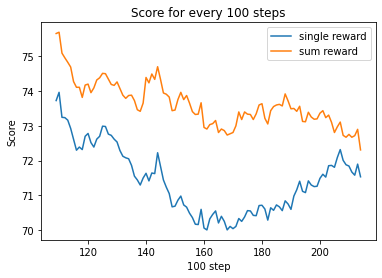

In [43]:
# plt.plot(EPS_baseline_rsingle_x.score_list[:215], label='VDBE hit@10')
# plt.plot(EPS_baseline_rsum_x.score_list[:215], label='VDBE hit@10')
# plt.plot(baseline100, label='baseline hit@10')
plt.plot(pd.Series(EPS_baseline_rsingle_x.score_list[:215]).rolling(110).mean(), label='single reward')
plt.plot(pd.Series(EPS_baseline_rsum_x.score_list[:215]).rolling(110).mean(), label='sum reward')
# plt.plot(pd.Series(baseline100).rolling(30).mean(), label='Baseline hit@10 ma 30')
plt.xlabel('100 step')
plt.ylabel('Score')
plt.title('Score for every 100 steps')
# plt.ylim([0.4, 0.6])
plt.legend()

In [23]:
with open('../Experiment/vdbe_100_max_target.pkl', 'wb') as file_pi:
  pickle.dump(res, file_pi, pickle.HIGHEST_PROTOCOL)

In [39]:
dqn.c_hist[-1]/sum(dqn.rec_list)

0.5406706451835664

In [17]:
'''
請不要關掉這ㄍ分頁 乾蝦哈咪搭
'''

'\n請不要關掉這ㄍ分頁 乾蝦哈咪搭\n'

In [24]:
with open('../Models/vdbe_100_target.pkl', 'wb') as file_pi:
  pickle.dump(dqn, file_pi, pickle.HIGHEST_PROTOCOL)

In [31]:
origin = 0.99
for i in range(68334):
  origin = 4 / ((i + 1) ** (1 / 4))
  if origin < 1:
    print(i, origin)
    break

256 0.9990258147229674


In [2]:
CONTEXT_REPS = pd.read_pickle('../../data/CONTEXT_REPS_CLEAN_ASID.pkl')


In [ ]:
CONTEXT_REPS.xs('100195065450589', level='asid')

,shipment_0,shipment_1,shipment_2,shipment_3,shipment_4,shipment_5,shipment_6,payment_0,payment_1,payment_2,...,s62,s63,s64,s65,s66,s67,s68,s69,s70,s71
stream,,,,,,,,,,,,,,,,,,,,,
9,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,-0.132498,-0.052705,-0.059136,0.041836,0.064853,0.021252,-0.002886,-0.051057,0.035917,0.002849
170,0.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.013412,0.063558,-0.048068,0.040219,0.045013,0.027529,0.072258,-0.095085,0.094784,0.060942
259,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,-0.127052,-0.020923,0.040821,0.069121,0.059461,-0.001729,-0.009453,-0.144311,0.036030,-0.033306
530,0.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,...,-0.139076,0.005469,0.052675,0.042398,0.069309,0.016650,0.002554,-0.084407,0.037224,0.093305
854,0.0,0.0,0.0,5.0,0.0,0.0,0.0,0.0,0.0,0.0,...,-0.094447,-0.079715,0.027152,-0.070138,-0.017507,0.095076,0.009913,-0.060667,-0.007425,0.063574
1116,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,...,-0.126453,0.003925,-0.011018,-0.011735,0.072177,0.071742,0.038208,-0.139593,0.070405,0.017937
1249,0.0,0.0,0.0,6.0,0.0,0.0,0.0,0.0,0.0,0.0,...,-0.043089,0.014795,-0.006246,0.022013,0.006497,0.025628,0.070256,-0.151250,0.118813,-0.030756
1741,0.0,0.0,0.0,6.0,0.0,0.0,0.0,0.0,0.0,0.0,...,-0.057637,-0.115033,-0.014697,0.006761,-0.065821,0.031127,-0.029407,-0.041986,0.064447,0.038614
1885,0.0,0.0,0.0,6.0,0.0,0.0,0.0,0.0,0.0,0.0,...,-0.121436,-0.081162,0.012896,-0.006772,0.102165,0.081686,0.059365,-0.083960,0.012134,-0.007319


In [ ]:
USER_LIST[19]

'100195065450589'